<a href="https://colab.research.google.com/github/pm2264/Magic/blob/main/magic_gamma_telescope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

dataset: https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

In [9]:
cols = ["fLength","fWidth","fSize","fConc","fConcl","fAsym","fM3Long","fM3Trans","fAlpha","fDist","class"]
df = pd.read_csv("magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConcl,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [10]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [11]:
df["class"]=( df["class"]=="g").astype(int)

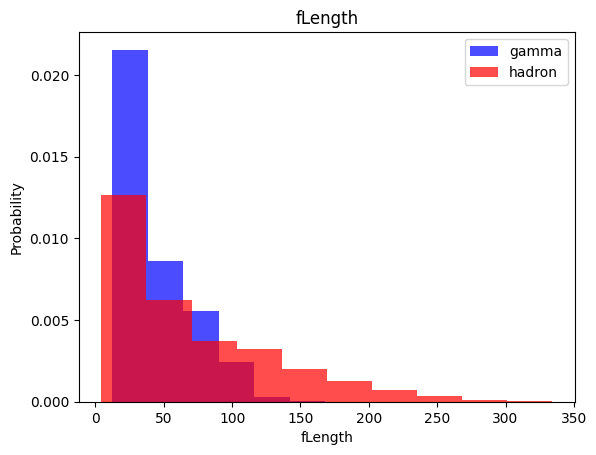

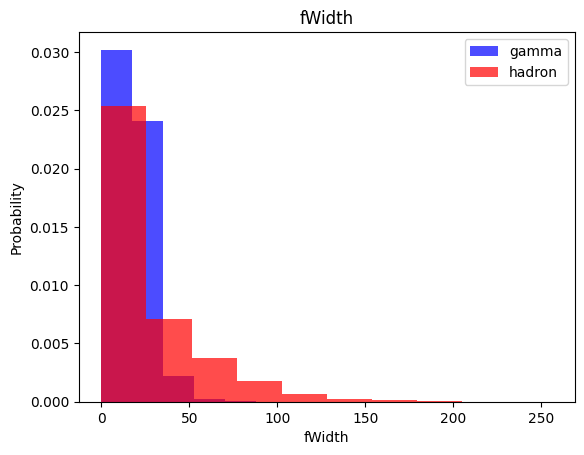

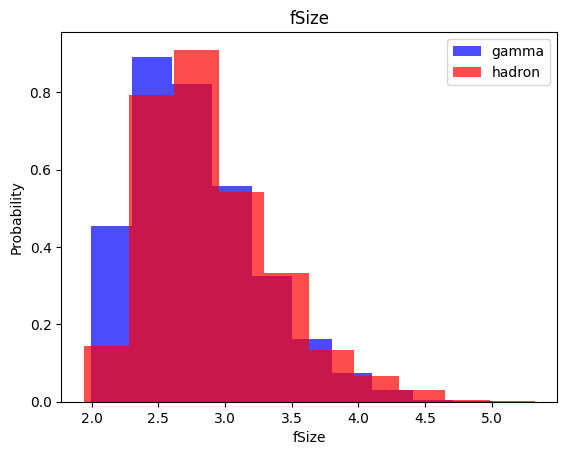

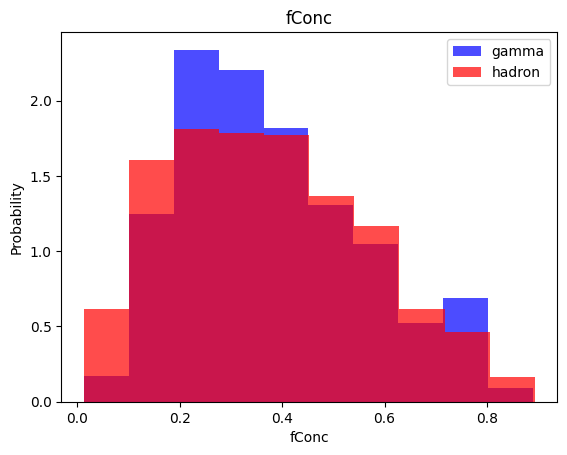

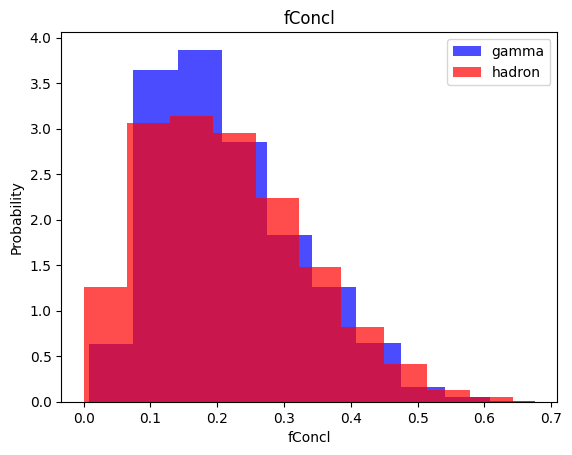

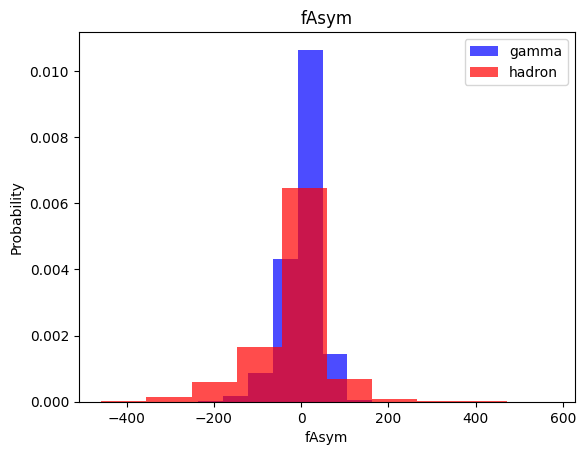

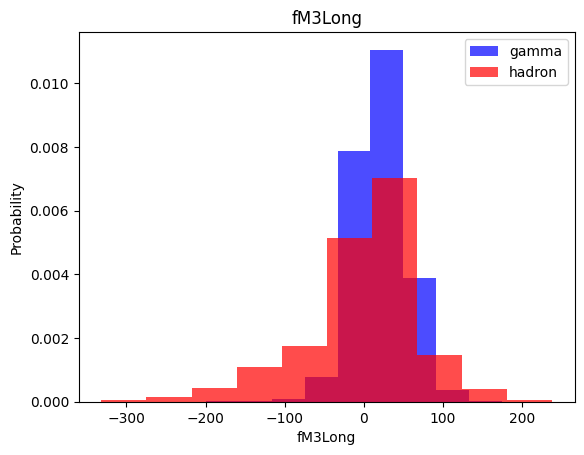

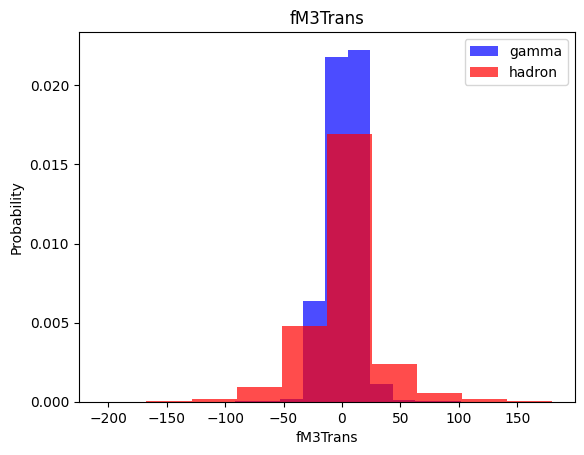

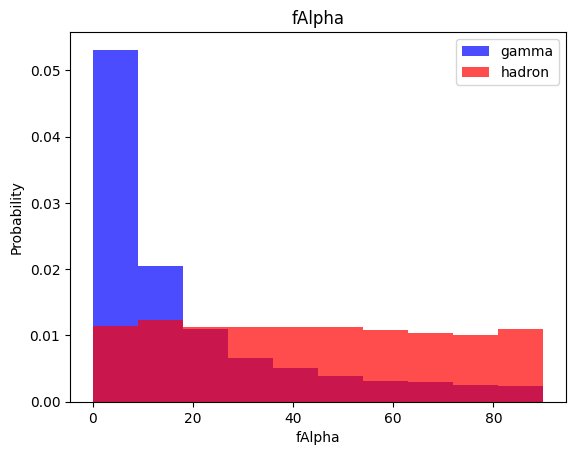

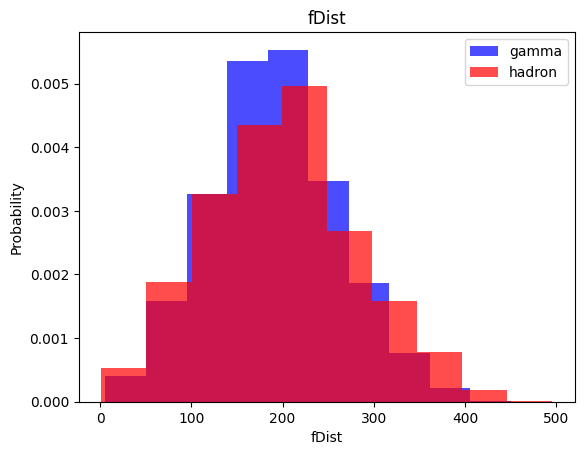

In [12]:
for label in cols[:-1]:
  plt.hist(df[df["class"]==1][label], color='blue', label='gamma', alpha=0.7, density=True)
  plt.hist(df[df["class"]==0][label], color='red', label='hadron', alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

#train, validation, test dataset

In [13]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [14]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

In [15]:
train, X_train, y_train = scale_dataset(train, oversample=True)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

#KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [21]:
y_pred = knn_model.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1329
           1       0.86      0.86      0.86      2475

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



#Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

In [24]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [25]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.41      0.51      1329
           1       0.74      0.90      0.81      2475

    accuracy                           0.73      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



#Log Regression

In [2]:
from sklearn.linear_model import LogisticRegression

In [26]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

In [27]:
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1329
           1       0.84      0.82      0.83      2475

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.79      0.78      0.79      3804



#SVM

In [28]:
from sklearn.svm import SVC

In [29]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [30]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1329
           1       0.89      0.90      0.90      2475

    accuracy                           0.87      3804
   macro avg       0.86      0.85      0.85      3804
weighted avg       0.87      0.87      0.87      3804



#Neural Net

In [31]:
import tensorflow as tf

In [32]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [33]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(10,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

16 nodes, dropout 0, lr 0.01, batch size 32


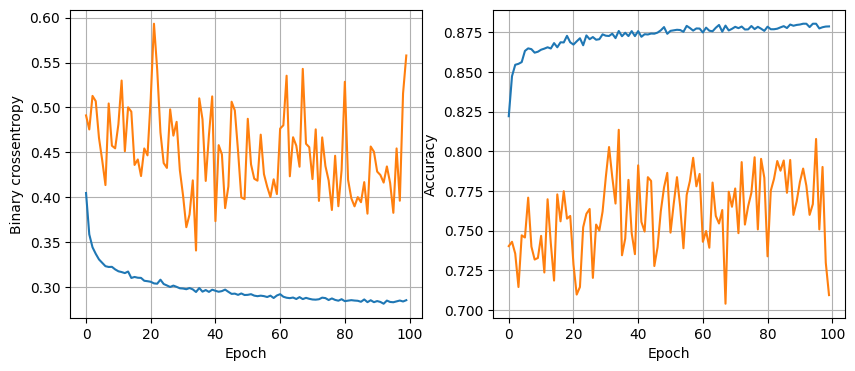

119/119 [==============================] - 0s 1ms/step - loss: 0.3356 - accuracy: 0.8672
16 nodes, dropout 0, lr 0.01, batch size 64


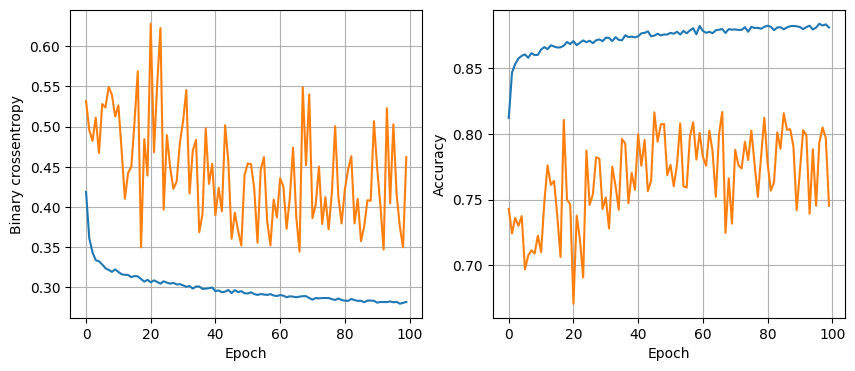

119/119 [==============================] - 0s 2ms/step - loss: 0.3179 - accuracy: 0.8762
16 nodes, dropout 0, lr 0.01, batch size 128


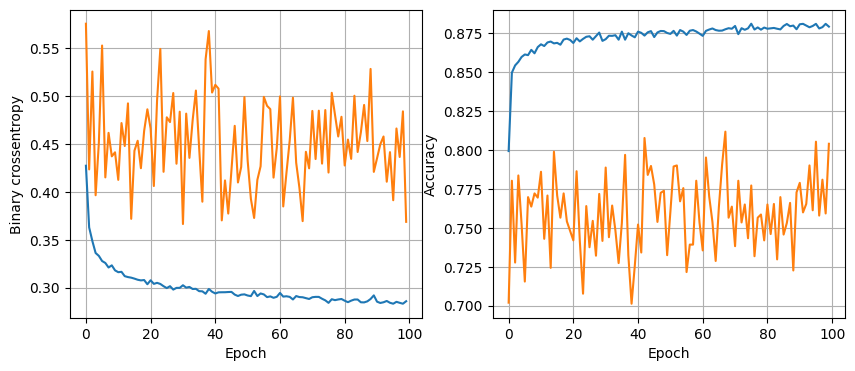

119/119 [==============================] - 0s 2ms/step - loss: 0.3241 - accuracy: 0.8659
16 nodes, dropout 0, lr 0.005, batch size 32


In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(X_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model

In [ ]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

In [ ]:
print(classification_report(y_test, y_pred))